<h1><b>Deep Learning Glottal Inverse Filtering: Vorhersagen </b></h1> 

Dieses Notebook beschreibt die Modellierung, das Training und die Evaulation des rekurrenten, neuronalen Netzes mit langem Kurzzeitgedächtnis (LSTM).

In [1]:
import os
import csv
import json

import torch
import torch.utils.data as data
from torch import nn
import torchaudio

import time
import random
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

from custom_dataset import GIFDataset
from model import BiLSTM
from train import Trainer
from test import Tester
from predict import Predictor
from visualize_signals import Visualizer 

C:\Users\Arbeit\Desktop\MedizinischeInformatik\Studienarbeit\PyLstmGif\env\lib\site-packages\torchaudio\extension\extension.py:14: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')
C:\Users\Arbeit\Desktop\MedizinischeInformatik\Studienarbeit\PyLstmGif\env\lib\site-packages\torchaudio\backend\utils.py:63: UserWarning: The interface of "soundfile" backend is planned to change in 0.8.0 to match that of "sox_io" backend and the current interface will be removed in 0.9.0. To use the new interface, do `torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False` before setting the backend to "soundfile". Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


<h2><b>1. Vobereitung</b></h2> 

Zunächst müssen alle notwendigen Pfade gesetzt werden:

In [2]:
model_configuration_folder_address = 'Model/ModelConfigurationFiles/'
model_folder_address = 'Model/'
dataset_address = 'D:/Ingo/Dokumente/Projekte_Programmierung/Sprachverarbeitung/Studienarbeit/SystematicSpeechGlottalFlowDataset/'
trained_models_folder_address = 'TrainedModels/'
prediction_dataset_address = 'Dataset/PredictionDataset/' 


debug_mode = False

Es wird vorausgesetzt, dass mit dem "Dataset_Configurator" die Listen "TrainFiles.csv" und "TestFiles.csv" erstellt wurden. Die Listen sollen im Ordner 'Dataset/' abgespeichert werden. 

In [3]:
# Check whether all necessary lists of the Dataset are available
try:
    open(dataset_address + 'TrainFiles.csv', mode='r')
    open(dataset_address + 'TestFiles.csv', mode='r')
    print('Checked Lists')
except:
    print('Not all necessary files are available')

Checked Lists


Prüfen ob GPU und cuda verfügbar sind:

In [4]:
def getDevice():
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
            print('Several GPUs found!')
    print(device)
    return device

device = getDevice()

cuda:0


## 2. Laden des trainierten Modells

Setze die Pfade zu dem trainierten Modell, welches geladen werden soll:

In [5]:
model_name = 'Bi_LSTM_HiddenSize_30_LearnRate_0_01_Signals_1000'
folder_name = 'MainStudy/Models/Trained_1000_Signals/'

In [6]:
def loadModelData(model_path, static_hyperparams):
    #Initialize Model
    model = BiLSTM(
            hyperparameters,
            debug_mode=False 
            
    )
    #Load Model, Optimizer and Definie Criterion
    model_data = torch.load(model_path)
    model.load_state_dict(model_data['model_state_dict'])
    optimizer = torch.optim.SGD(model.parameters(), hyperparameters['learning_rate']) 
    optimizer.load_state_dict(model_data['optimizer_state_dict'])
     
    epoch = model_data['epoch']
    training_loss = model_data['loss']
    
    return model, optimizer, epoch, training_loss


trained_model_configuration_file_address = trained_models_folder_address + folder_name + model_name + '.json'
trained_model_path = trained_models_folder_address + folder_name + model_name + '.pth'


with open(trained_model_configuration_file_address) as file:
    hyperparameters = json.load(file)
print(hyperparameters)


model, optimizer, epoch, training_loss = loadModelData(trained_model_path, hyperparameters)
device = getDevice()
model.to(device)

#Achtung: Bei Veränderung der Fehlerfunktion muss auch die JSON-Datei verändert werden!
if hyperparameters['criterion']=='MSE':
    criterion = nn.MSELoss(reduction="none")
    print('MSE-LOSS selected!')
if hyperparameters['criterion']=='COSINE':
    criterion= nn.CosineEmbeddingLoss()
    print('COSINE-LOSS selected!')


{'sequence_length': 120, 'window_stride': 120, 'batch_size': 1, 'number_epochs': 1, 'input_size_lstm': 1, 'output_size_linear': 1, 'output_sample_rate': 8000, 'bidirectional_lstm': True, 'number_layers_lstm': 1, 'learning_rate': 0.01, 'hidden_size_lstm': 30, 'criterion': 'MSE', 'gradient_clip': True, 'gradient_clip_value': 10}
cuda:0
MSE-LOSS selected!


## 3. Vorhersage von Signalen

Im Ordner Dataset/PredictDataset sind einige Test-Signale enthalten (auf denen nicht trainiert wurde)

In [7]:
debug_mode = True
file_name = 'Berliner_087_RangeNormal_OffsetNormal_SpeedFast_Modal'
noise_type = '_NoNoise'

In [25]:
speech_file_address = str(prediction_dataset_address + file_name + noise_type + '.wav')
glottal_flow_derivative_file_address = str(prediction_dataset_address + file_name + '_GlottalFlowDerivative.misc')
glottal_flow_file_address =  str(prediction_dataset_address + file_name + '.misc')

print(speech_file_address)
print(glottal_flow_derivative_file_address)
print(glottal_flow_file_address)


predictor = Predictor(hyperparameters, device)

signals, signal_loss = predictor.predictSyntheticSignals(model, 
                           criterion, 
                           speech_file_address, 
                           glottal_flow_derivative_file_address, 
                           glottal_flow_file_address)

speech_signal = signals[0]
glottal_flow_derivative_signal = signals[1]
glottal_flow_signal = signals[2]
predicted_glottal_flow_derivative_signal  = signals[3]
print('Signal-Loss:' +str(signal_loss))

Dataset/PredictionDataset/Berliner_087_RangeNormal_OffsetNormal_SpeedFast_Modal_NoNoise.wav
Dataset/PredictionDataset/Berliner_087_RangeNormal_OffsetNormal_SpeedFast_Modal_GlottalFlowDerivative.misc
Dataset/PredictionDataset/Berliner_087_RangeNormal_OffsetNormal_SpeedFast_Modal.misc
Signal-Loss:0.3946410119533539


### Visualisierung der Vorhersage auf synthetischen Signalen

Hinweis: Signale sind Bestandteil des Test-Datensatzes

In [26]:
from scipy import integrate

In [45]:
def integrateSignal(signal):
    
    sample_rate = 8000
    
    #integrated_signal = integrate.cumtrapz(signal.cpu() ,initial=0)
    integrated_signal = integrate.trapz(signal.cpu())
    
    time = np.linspace(0, (len(integrated_signal) / sample_rate) * 1000,
                           num=len(integrated_signal))
    
    plt.plot(time[0:20000], integrated_signal[0:20000])


mean = torch.mean(predicted_glottal_flow_derivative_signal.cpu())
print(mean)


integrateSignal(predicted_glottal_flow_derivative_signal-mean)
#integrateSignal(glottal_flow_derivative_signal)

tensor(0.1026)


TypeError: object of type 'numpy.float32' has no len()

In [ ]:
def integrateSignal2(predicted_glottal_flow_derivative_signal):
    
    sample_rate = 8000
    
    predicted_glottal_flow_signal = integrate.cumtrapz(predicted_glottal_flow_derivative_signal.cpu() ,initial=0)
    
    time = np.linspace(0, (len(predicted_glottal_flow_derivative_signal) / sample_rate) * 1000,
                           num=len(predicted_glottal_flow_derivative_signal))
    
    plt.plot(time[1200:2000], predicted_glottal_flow_signal[1200:2000])

integrateSignal2(predicted_glottal_flow_derivative_signal)

Number Sequences:112
Number Sequences:112
Number Sequences:112
Number Sequences:112


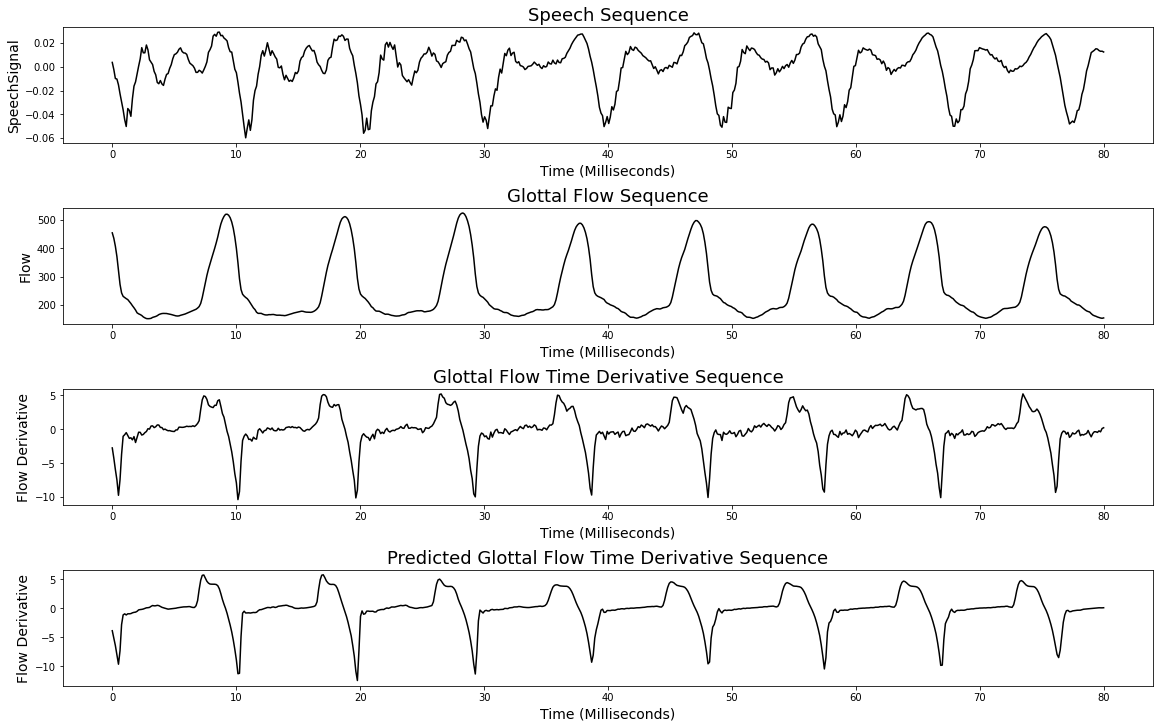

In [33]:
sequence_length = 640 #Abtastpunkte pro Sequenz
stride = 120 #Schrittweite

visualizer = Visualizer(sequence_length, stride, hyperparameters)


sequence_index = 14
save_figure = False #True
visualizer.visualizeSyntheticSignals(signals, sequence_index, save_figure)    

### Visualisierung der Vorhersage auf realen Signalen und Vergleich mit EGG

 <img src="img/peaksEGG.png" alt="SearchSpace" width="400" height="400">

Bildquelle: http://voiceresearch.free.fr/egg/

Pfad zum EGG-Signal

In [96]:
egg_signal_address = 'Dataset/PredictionDataset/BITS-US/BAS_BITS_US_2/DATA/SES1002/US10020005_1.wav'
speech_signal_address = 'Dataset/PredictionDataset/BITS-US/BAS_BITS_US_2/DATA/SES1002/US10020005_0.wav' #Nah-Feld

Vorhersage:

In [97]:
predictor = Predictor(hyperparameters, device)

signals = predictor.predictAndGetEGGSignal(model,  
                           speech_signal_address, 
                           egg_signal_address)

speech_signal = signals[0]
predicted_glottal_flow_derivative_signal = signals[1]
egg_signal = signals[2]
egg_derivative_signal = signals[3]

Visualisierung:

Number Sequences:91
Number Sequences:91
Number Sequences:91
Number Sequences:91


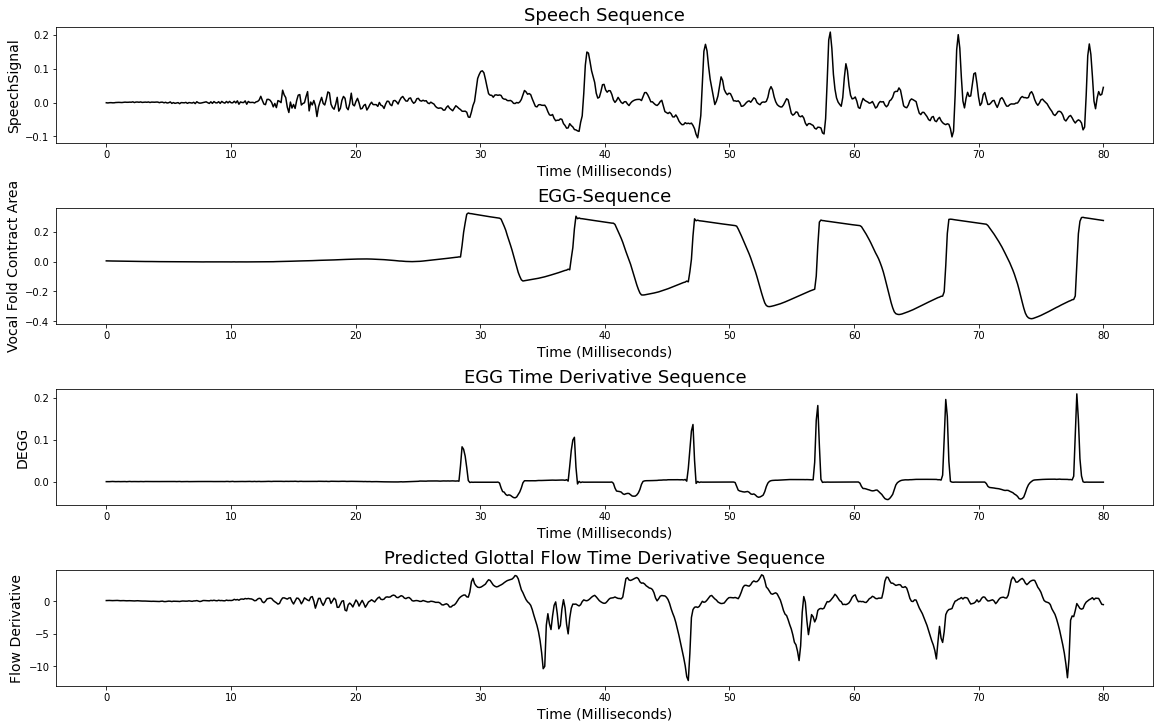

In [120]:
sequence_length = 640 #Abtastpunkte pro Sequenz
stride = 640 #Schrittweite

visualizer = Visualizer(sequence_length, stride, hyperparameters)

sequence_index = 41
save_figure = False #True
visualizer.visualizePredictionAndEGGSignal(signals, sequence_index, save_figure)    